# Milestone 3 
## Shear Wave Decay
Todo:
- observe the density when it start with a sinus distribution along the x axis
- observe what happens when the velocity-field in x direction starts with a sinusoidal variation
- calculate the kinematic viscosity 
    - what happens with different omegas
    - compare it with the analytic result

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from source.algorithms.latticeBoltzman import LatticeBoltzmannMethod 
from source.data.ExperimentData import ExperimentVar
import source.data.ExperimentData as ed
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

In [2]:
#set up
var = ExperimentVar()
X =  var.lattice_shape[0]
Y =  var.lattice_shape[1]
density_field, velocity_field = ed.sinus_density(grid_shape=var.lattice_shape,epsilon=var.epsilon, rho_zero= var.rho)
densities = np.zeros((var.time_steps, X))
max_position = np.argmax(density_field[0][:])
max(density_field[0,:]) 
plt.style.use('classic')

# different helper functions#

In [3]:
def get_viscosity(omega: float):
    visc = 1. / 3. * (1. / omega - 0.5)
    return visc
def analytical_decay(t: int, x: np.ndarray, X: int, omega: float) -> float:
    v = get_viscosity(omega=omega)
    lx = 2.0 * np.pi / X
    return var.epsilon * np.exp(- v * lx ** 2 * t) * np.sin(lx * x)

## Animated shear wave decay

In [4]:
def callback(lattice: LatticeBoltzmannMethod, t: int) -> None:
    densities[t] =  lattice.getDensity()[0]

In [5]:

lattice = LatticeBoltzmannMethod(var.lattice_shape[0],var.lattice_shape[1], omega=var.omega , init_density=density_field, init_velocity=velocity_field, init_plot=True)
lattice.execute(timesteps=var.time_steps, callback=callback)
# lattice.display_animation()
plt.close()


100%

# simple sinus density shear wave decay


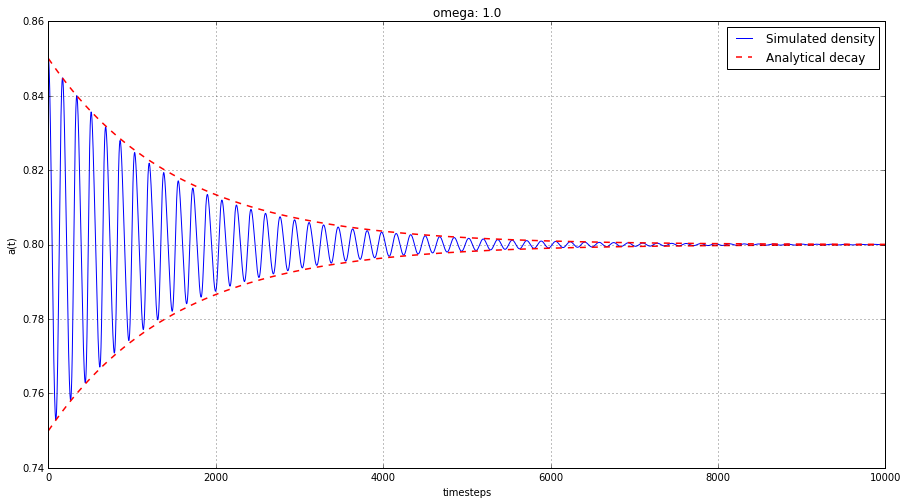

In [6]:
figure, ax = plt.subplots(figsize=(15,8))
x_axis = np.arange(var.time_steps)

ax.plot(x_axis, densities[:,max_position], label="Simulated density")
ax.plot(x_axis, var.rho + analytical_decay(x_axis,max_position, X, var.omega), label="Analytical decay", linestyle="dashed", lw=1.5, color="red")
ax.plot(x_axis, var.rho - analytical_decay(x_axis,max_position, X, var.omega), linestyle="dashed", lw=1.5, color="red")
plt.title("omega: " + str(var.omega))
plt.xlabel("timesteps")
plt.ylabel("a(t)")
ax.grid()
ax.legend()
plt.savefig(f'figures/Milestone3/ShearWaveDecay.png', bbox_inches='tight')
plt.show()

# Multiple Omegas Shear Wave decay

100%

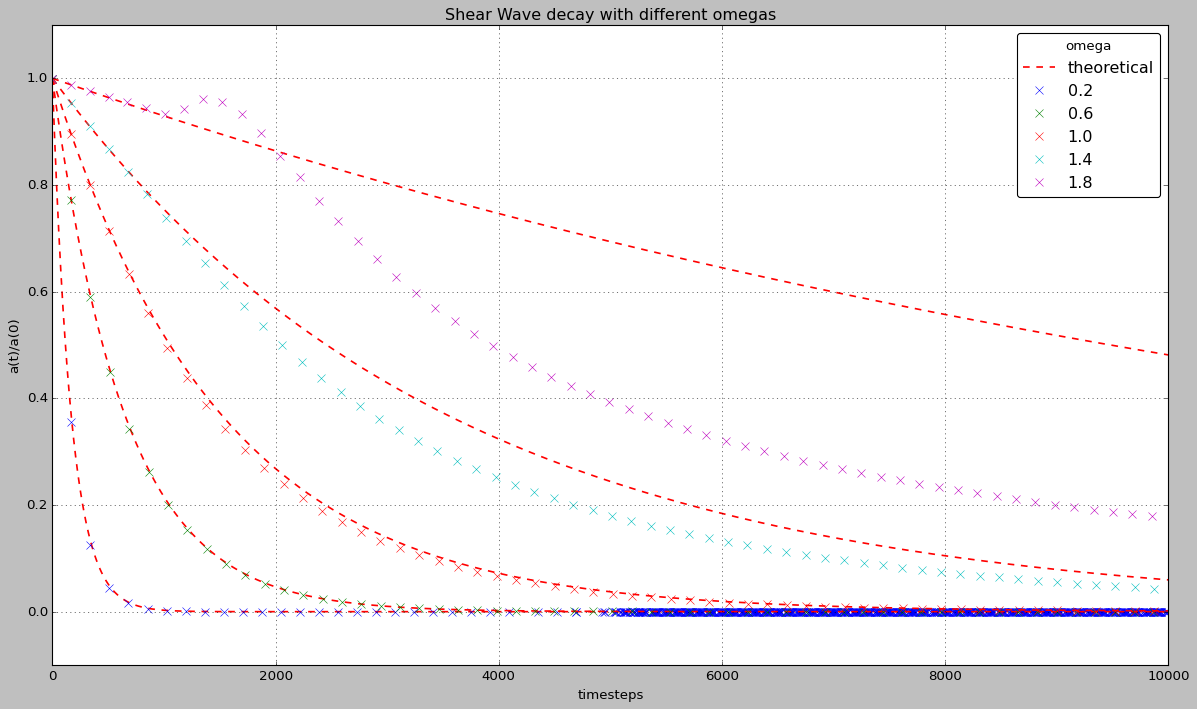

In [7]:
#make simulation for different omegas
different_omegas = np.arange(0.2, 2.0, 0.4)
x_axis = np.arange(var.time_steps)
diff_densities = np.zeros((different_omegas.shape[0],var.time_steps, X))
plt.close()
# figure, ax = plt.plot(figsize=(18,8))
plt.style.use('classic')
plt.figure(figsize=(18,10))
for idx, omega in enumerate(different_omegas):
    densities = np.zeros((var.time_steps, X))
    lattice = LatticeBoltzmannMethod(var.lattice_shape[0],var.lattice_shape[1], omega , init_density=density_field, init_velocity=velocity_field, init_plot=False)
    lattice.execute(timesteps=var.time_steps, callback=callback)
    diff_densities[idx, ...] = densities
    #get absolut function for more function points
    absolut_function = np.abs(densities[:,max_position] - var.rho)
    #normalizing
    absolut_function = absolut_function / var.epsilon
    maximas =  argrelextrema(absolut_function, np.greater, mode='wrap')
    plt.plot(x_axis, (analytical_decay(x_axis,max_position, X, omega=omega) / var.epsilon), label="theoretical" if idx==0 else "", linestyle="dashed", lw=1.5, color="red")
    plt.plot(maximas[0][::2], absolut_function[maximas[0]][::2],'x', label=round(omega,2), markersize=8, linewidth=4)


plt.title("Shear Wave decay with different omegas")
plt.xlabel("timesteps")
plt.ylabel("a(t)/a(0)")
plt.ylim(-0.1, 1.1)
plt.grid()
plt.legend(title="omega" , loc='upper right', fancybox=True, numpoints=1)
plt.savefig(f'figures/Milestone3/ShearWaveDecayDifferentOmega.png', bbox_inches='tight')
plt.show()

# Kinematic Viscosity

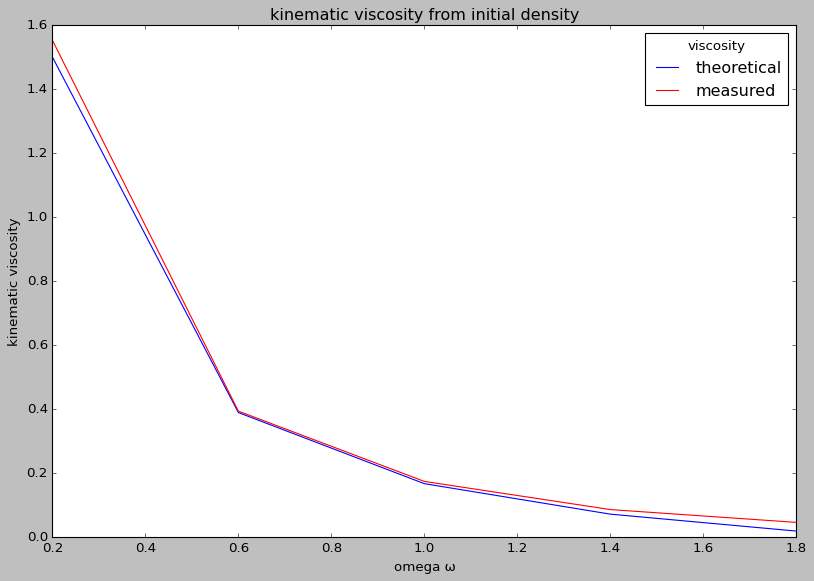

In [8]:

theoretical_visc = np.zeros((different_omegas.shape[0]))
measured_visc = np.zeros((different_omegas.shape[0]))
# peaks = np.zeros((different_omegas.shape[0]))
for idx, omega in enumerate(different_omegas):
    # theoretical viscosity
    theoretical_visc[idx] = get_viscosity(omega)
    # measured viscosity
    quantities = diff_densities[idx, ...][:,max_position]
    densities = np.array(np.abs(quantities-var.rho) )
    #get absolut function for more function points
    peaks = argrelextrema(densities, np.greater, mode='wrap')[0]
    densities = densities[peaks]
    measured_visc[idx] = curve_fit(lambda t, v: var.epsilon * np.exp(-v * t * (2*np.pi/X)**2),
                                   xdata=peaks,
                                   ydata=densities)[0][0]
plt.figure(figsize=(12, 8))
plt.title("kinematic viscosity from initial density")
plt.xlabel("omega ω")
plt.ylabel("kinematic viscosity")
plt.plot(different_omegas, theoretical_visc, 'b', label="theoretical")
plt.plot(different_omegas, measured_visc, 'r', label="measured")
plt.legend(title="viscosity")
plt.savefig(f'figures/Milestone3/KinematicViscosity.png', bbox_inches='tight')


# Second Distribution (viscosity)

In [9]:
profiles = []
velocities = np.zeros((var.time_steps, Y))
def callback(lattice: LatticeBoltzmannMethod, t: int) -> None:
    velocities[t] = lattice.getVelocity()[1,:, max_position]
    profiles.append(np.abs(lattice.getVelocity()[1, max_position ,0]))

density_field, velocity_field = ed.sinus_velocity(grid_shape=var.lattice_shape,epsilon=var.epsilon)

max_position = np.argmax(velocity_field[1][:][0])
lattice = LatticeBoltzmannMethod(var.lattice_shape[0],var.lattice_shape[1], omega=var.omega , init_density=density_field, init_velocity=velocity_field, init_plot=True)
lattice.execute(timesteps=var.time_steps, callback=callback)
# lattice.display_animation()
plt.close()
max_position

100%

0

## animate velocity y-axis


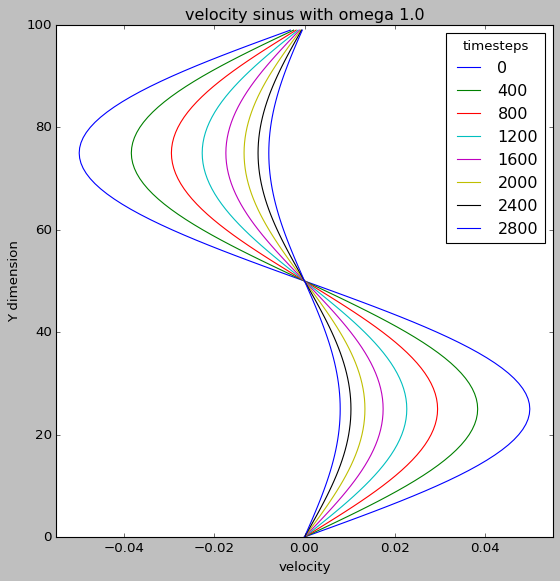

In [10]:
plt.figure(figsize=(8,8))
velo_timesteps = np.arange(0, 3000, 400)
for time in velo_timesteps:
     plt.plot(velocities[time,:], range(Y), label=time)
plt.legend(title="timesteps")
plt.title("velocity sinus with omega "+str(var.omega))
plt.xlabel("velocity")
plt.ylabel("Y dimension")
plt.xlim(-var.epsilon*1.1, var.epsilon*1.1)
plt.savefig(f'figures/Milestone3/VelocityOverTime.png', bbox_inches='tight')
plt.show()